## Load Dataset and Visualize Images


In [14]:
import torch
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

def get_target_index(dataset):
    '''
    Given a dataset, this function returns a dictionary of classes, where the value of each class 
    is a dictionary containing the class indices and the number of datapoints in the class.
    
    Input:
        dataset (IMAGEFOLDER)
            Dataset should be ImageFolder class.
        
    Output:
        idx_dct (DCT)
            Nested dictionary with the class name as key, and a dictionary containing the
            'indices' and 'length' of the class as values.
            Example format:
            idx_dct = { 'class_A':{
                        'indices': [1,2,3,4,5],
                        'length': 5
                        },
                        'class_B':{
                        'indices': [6,7,8],
                        'length': 3
                        },
                        'class_C':{
                        'indices': [100,101,102,103],
                        'length': 4
                        }}
    '''
    targets = torch.tensor([t[1] for t in dataset.samples])
    idx_dct = {}
    
    for k,v in dataset.class_to_idx.items():
        idx_dct[k] = {'indices': (targets == v).nonzero().reshape(-1)}
        idx_dct[k]['length'] = len(idx_dct[k]['indices'])
        
    return idx_dct


# Root directory for dataset
dataroot = 'images'

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this size using a transformer.
image_size = 64

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [15]:
# Create the novel dataset
novel_dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                           transforms.Resize(image_size),
                           transforms.CenterCrop(image_size),
                           transforms.RandomHorizontalFlip(p=0.5),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

target_idx_dct = get_target_index(novel_dataset)
for k,v in target_idx_dct.items():
    print(f"Class {k} has {v['length']} entries.")

Class cartoon has 9924 entries.
Class cyberpunk has 9859 entries.
Class horror has 9868 entries.
Class noir has 3567 entries.
Class western has 6344 entries.


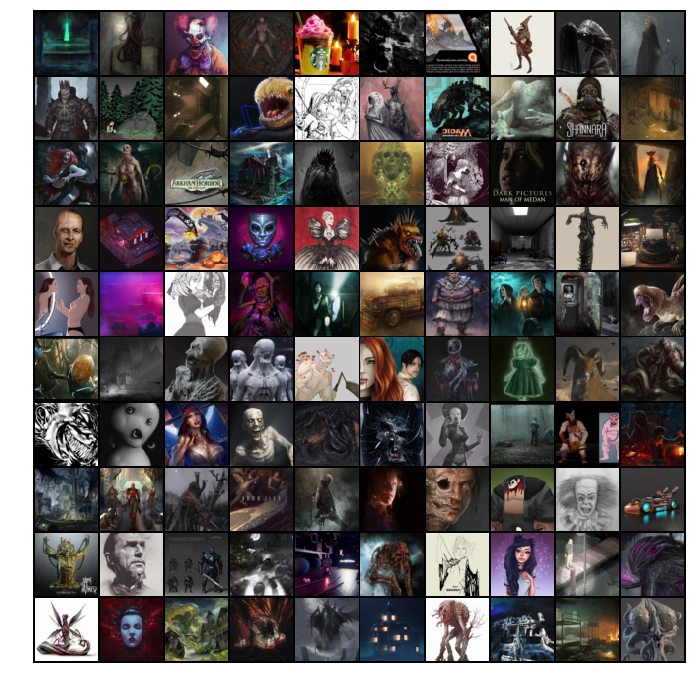

In [16]:
def plot_batch(dataloader):    
    '''
    Plot images from a dataloader
    '''
    real_batch = next(iter(dataloader))
    plt.figure(figsize=(12,12))
    plt.axis("off")
    plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:100], padding=2, nrow=10, normalize=True).cpu(),(1,2,0)))


genres = ['cyberpunk','noir','horror','western','cartoon','steampunk']

dataloader = torch.utils.data.DataLoader(novel_dataset, batch_size = batch_size, 
                                         sampler = SubsetRandomSampler(target_idx_dct[genres[2]]['indices']))

plot_batch(dataloader)

In [18]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F
import torch.utils.data

from torchvision.models.inception import inception_v3

import numpy as np
from scipy.stats import entropy

def inception_score(imgs, cuda=False, batch_size=32, resize=True, splits=1):
    """
    Computes the inception score of the generated images imgs
    imgs -- Torch dataset of (3xHxW) numpy images normalized in the range [-1, 1]
    cuda -- whether or not to run on GPU
    batch_size -- batch size for feeding into Inception v3
    splits -- number of splits
    """
    N = len(imgs)

    assert batch_size > 0
    assert N > batch_size

    # Set up dtype
    if cuda:
        dtype = torch.cuda.FloatTensor
    else:
        if torch.cuda.is_available():
            print("WARNING: You have a CUDA device, so you should probably set cuda=True")
        dtype = torch.FloatTensor

    # Set up dataloader
    dataloader = torch.utils.data.DataLoader(imgs, batch_size=batch_size)

    # Load inception model
    inception_model = inception_v3(pretrained=True, transform_input=False).type(dtype)
    inception_model.eval();
    up = nn.Upsample(size=(299, 299), mode='bilinear').type(dtype)
    
    def get_pred(x):
        if resize:
            x = up(x)
        x = inception_model(x)
        return F.softmax(x).data.cpu().numpy()

    # Get predictions
    preds = np.zeros((N, 1000))

    for i, batch in enumerate(dataloader, 0):
        batch = batch.type(dtype)
        batchv = Variable(batch)
        batch_size_i = batch.size()[0]

        preds[i*batch_size:i*batch_size + batch_size_i] = get_pred(batchv)

    # Now compute the mean kl-div
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)
    

In [ ]:
class IgnoreLabelDataset(torch.utils.data.Dataset):

    def __init__(self, orig):
        self.orig = orig

    def __getitem__(self, index):
        return self.orig[index][0]

    def __len__(self):
        return len(self.orig)
    

cifar = dset.CIFAR10(root='data/', download=True,
                         transform = transforms.Compose([
                             transforms.Resize(32),
                             transforms.ToTensor(),
                             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                         ])
)

print ("Calculating Inception Score...")
print (inception_score(IgnoreLabelDataset(cifar), cuda=False, batch_size=32, resize=True, splits=10))


In [20]:
print ("Calculating Inception Score for Novel Dataset...")
print (inception_score(IgnoreLabelDataset(novel_dataset), cuda=False, batch_size=32, resize=True, splits=10))


Calculating Inception Score for Novel Dataset...


/anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


(8.641983380155397, 0.6726821596408179)
